In [139]:
from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cameo import phenotypic_phase_plane
plotter = PlotlyPlotter()

## Brief summary

Here different substrates are tested first on LB rich media and later on M9 minimal media.

We assess the ratio of production between violacein and deoxyviolacein as explained in the report. Depending on whether we are working with rich media or minimal media the ratios change. For LB media deoxyviolacein production is 1.9 times higher than violacein production. For M9 media deoxyviolacein production is 4.2 times lower than violacein production.

The default boundaries are set to -10 for uptake rates, so we change it to -21.5, the value calculated for glucose uptake experimentally [Long et al. 2017]. Since no information about other substrates is found, we use the same boundary for all the studied substrates. The medium includes oxygen, necessary for violacein production, which we set to -1000, being the substrate the limiting factor.


The results obtained match the studied substrate uptake rates by [Hoffart et al. 2017]. *V. natriegens* was found to have the highest growth rate when growing on sucrose (3.14 h-1 on LB, 0.89 h-1 on M9). We obtained the following results for glucose (2.84 h-1 on LB, 0.72 h-1 on M9) and N-acetylglucosamine (2.68 h-1 on LB, 0.62 h-1 on M9), D-mannitol (2.84 h-1 on LB, 0.72 h-1 on M9) and glycerol (2.67 h-1 on LB, 0.54 h-1 on M9). The results are not completely accurate but give an idea on how they could benefit violacein production.

# Model with media LB with added violacein

In [164]:
model_LB_vio_fad=read_sbml_model('Models/model_VN_LB_vio-fad.xml')

Added ratio constraint in LB media between Violacein and Deoxyviolacein.

In [167]:
ratio = model_LB_vio_fad.problem.Constraint(
    1.9*model_LB_vio_fad.reactions.Violacein.flux_expression - model_LB_vio_fad.reactions.Deoxyviolacein.flux_expression,
    lb=0, ub=0)
model_LB_vio_fad.add_cons_vars(ratio)

We check what it takes up from the media for growth.

In [191]:
model_LB_vio_fad.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
adn_e,EX_adn_e,1.271,10,1.63%
arg__L_e,EX_arg__L_e,10,6,7.68%
asp__L_e,EX_asp__L_e,10,4,5.12%
ca2_e,EX_ca2_e,0.01479,0,0.00%
cl_e,EX_cl_e,0.01479,0,0.00%
cmp_e,EX_cmp_e,10,9,11.53%
cobalt2_e,EX_cobalt2_e,0.0002841,0,0.00%
cu2_e,EX_cu2_e,0.002014,0,0.00%
dcyt_e,EX_dcyt_e,10,9,11.53%
fe2_e,EX_fe2_e,0.01907,0,0.00%


## Glucose as substrate

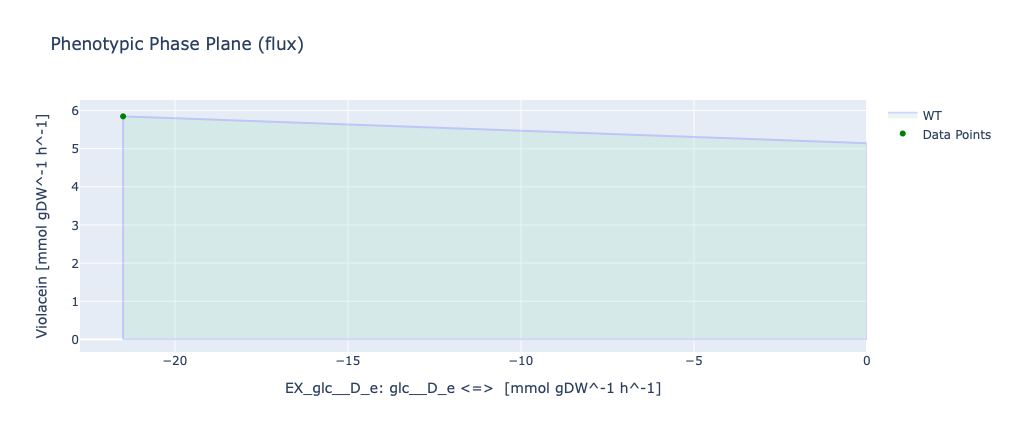

Setting glucose boundary to -21.5 and oxygen to -61:
- The optimal glucose uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol Glucose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -3.5833333333333335
- Growth rate for V. natriegens [h^-1]: 6.161849702549288
- Max. violacein production [mmol gDW^-1 h^-1]: 5.846206398822336
- Theoretical maximum yield per carbon [mmol_vio / Cmol_glc]: 1.6314994601364656


In [219]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    # Setting the medium and boundary conditions
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_LB_vio_fad.reactions.EX_glc__D_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_LB_vio_fad.optimize().fluxes.Growth
    model_LB_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    # Phenotypic phase plane of glucose-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glc__D_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)

    # Computing the glucose uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_glc__D_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of glucose
    cmol = (max(v)/6)
    
    # Computing maximum yield
    violacein_glc_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    
    print('Setting glucose boundary to -21.5 and oxygen to -61:')
    print("- The optimal glucose uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol Glucose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_glc]:', violacein_glc_yield)

## Sucrose as substrate

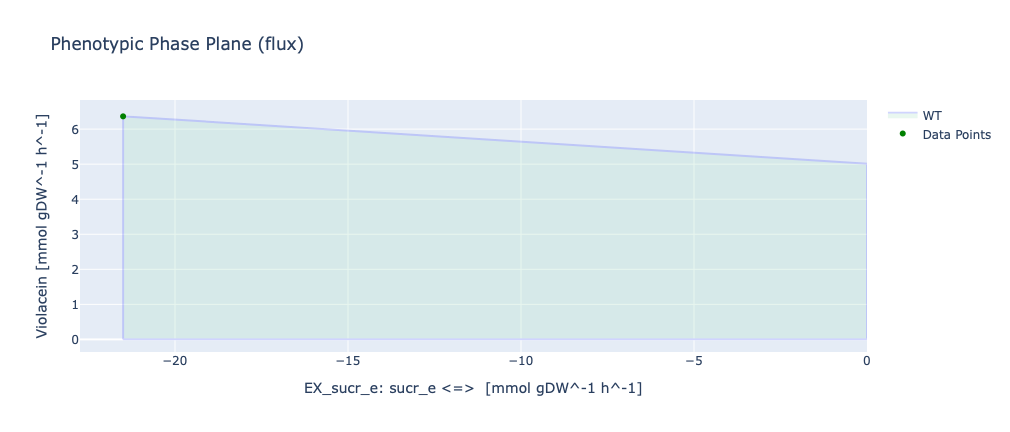

Setting sucrose boundary to -21.5 and oxygen to -61:
- The optimal sucrose uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -1.7916666666666667
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 6.826937514491315
- Max. violacein production [mmol gDW^-1 h^-1]: 6.363556462856561
- Theoretical maximum yield per carbon [mmol_vio / Cmol_sucr]: 3.551752444385057


In [221]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_sucr_e'] = 10
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_LB_vio_fad.reactions.EX_sucr_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_LB_vio_fad.optimize().fluxes.Growth
    model_LB_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of sucrose-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_sucr_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)

    # Computing the sucrose uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_sucr_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of sucrose
    cmol = (max(v)/12)
    
    # Computing maximum yield
    violacein_sucr_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting sucrose boundary to -21.5 and oxygen to -61:')
    print("- The optimal sucrose uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_sucr]:', violacein_sucr_yield)

## D-mannitol as substrate

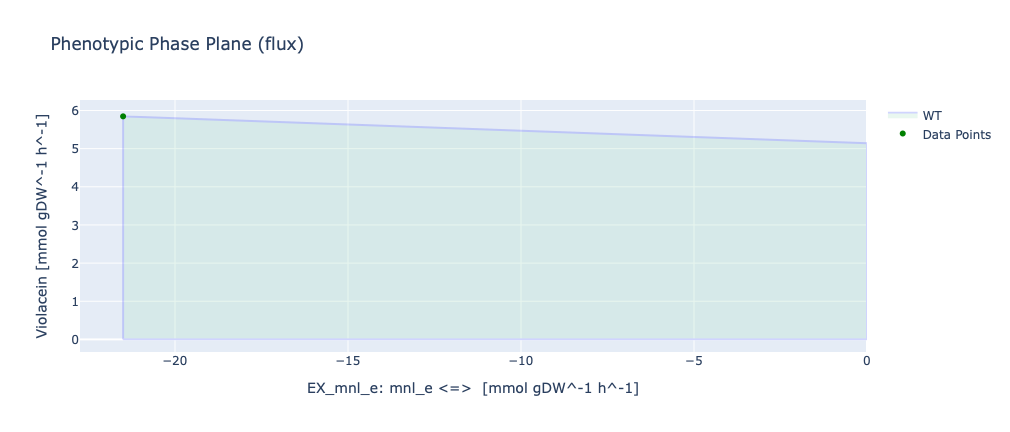

Setting D-mannitol boundary to -21.5 and oxygen to -61:
- The optimal D-mannitol uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol D-mannitol uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -3.5833333333333335
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 6.161849702549269
- Max. violacein production [mmol gDW^-1 h^-1]: 5.846206398822334
- Theoretical maximum yield per carbon [mmol_vio / Cmol_mnl]: 1.6314994601364652


In [220]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:

    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_mnl_e'] = 10
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_LB_vio_fad.reactions.EX_mnl_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_LB_vio_fad.optimize().fluxes.Growth
    model_LB_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of mannitol-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_mnl_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    
    # Computing the D-mannitol uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_mnl_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of D-mannitol
    cmol = (max(v)/6)
    
    # Computing maximum yield
    violacein_mnl_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting D-mannitol boundary to -21.5 and oxygen to -61:')
    print("- The optimal D-mannitol uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol D-mannitol uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_mnl]:', violacein_mnl_yield)

## N-acetyl-D-glucosamine as substrate

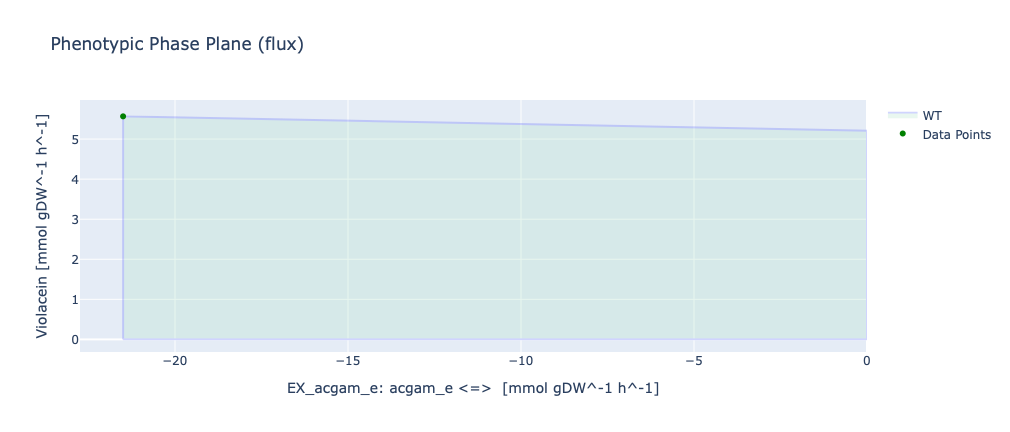

Setting N-acetyl-D-glucosamine boundary to -21.5 and oxygen to -61:
- The optimal N-acetyl-D-glucosamine uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -2.6875
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 5.819564050293167
- Max. violacein production [mmol gDW^-1 h^-1]: 5.566769967788654
- Theoretical maximum yield per carbon [mmol_vio / Cmol_acgam]: 2.0713562670841505


In [222]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_acgam_e'] = 10
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_LB_vio_fad.reactions.EX_acgam_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_LB_vio_fad.optimize().fluxes.Growth
    model_LB_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of glycerol-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_acgam_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    
    # Computing the N-acetyl-D-glucosamine uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_acgam_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of N-acetyl-D-glucosamine
    cmol = (max(v)/8)
    
    # Computing maximum yield
    violacein_acgam_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting N-acetyl-D-glucosamine boundary to -21.5 and oxygen to -61:')
    print("- The optimal N-acetyl-D-glucosamine uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_acgam]:', violacein_acgam_yield)

## Glycerol as substrate

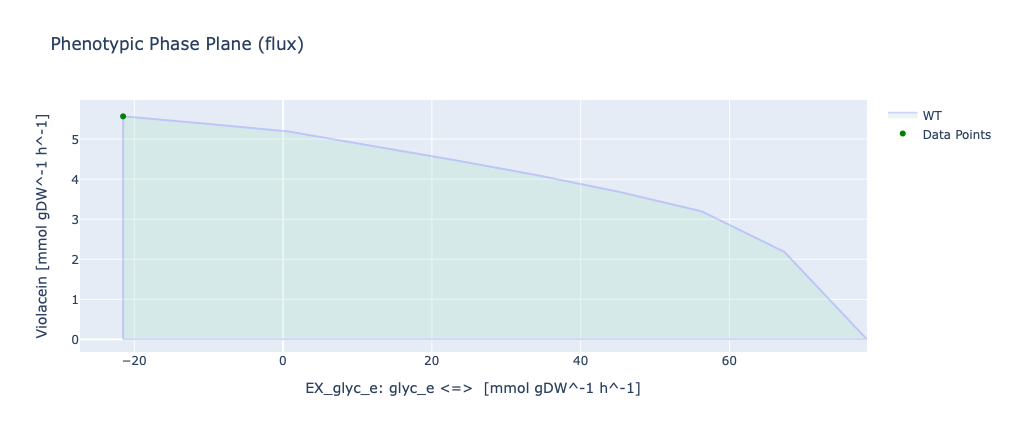

Setting glycerol boundary to -21.5 and oxygen to -61:
- The optimal glycerol uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -7.166666666666667
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 5.802041903489457
- Max. violacein production [mmol gDW^-1 h^-1]: 5.566780205359969
- Theoretical maximum yield per carbon [mmol_vio / Cmol_glyc]: 0.7767600286548794


In [223]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_glyc_e'] = 10
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_LB_vio_fad.reactions.EX_glyc_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_LB_vio_fad.optimize().fluxes.Growth
    model_LB_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of glycerol-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glyc_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)

    # Computing the glycerol uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_glyc_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of glycerol
    cmol = (max(v)/3)
    
    # Computing maximum yield
    violacein_glyc_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting glycerol boundary to -21.5 and oxygen to -61:')
    print("- The optimal glycerol uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_glyc]:', violacein_glyc_yield)

# Model with media M9 with added violacein

In [210]:
model_M9_vio_fad=read_sbml_model('Models/model_VN_M9_vio-fad.xml')

Added ratio constraint in M9 media between Violacein and Deoxyviolacein.

In [211]:
ratio = model_M9_vio_fad.problem.Constraint(
    model_M9_vio_fad.reactions.Violacein.flux_expression - 4.2*model_M9_vio_fad.reactions.Deoxyviolacein.flux_expression,
    lb=0, ub=0)
model_M9_vio_fad.add_cons_vars(ratio)

We check what it takes up from the media for growth.

In [212]:
model_M9_vio_fad.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.003742,0,0.00%
cl_e,EX_cl_e,0.003742,0,0.00%
cobalt2_e,EX_cobalt2_e,7.189E-05,0,0.00%
cu2_e,EX_cu2_e,0.0005097,0,0.00%
fe2_e,EX_fe2_e,0.004827,0,0.00%
fe3_e,EX_fe3_e,0.005613,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
h_e,EX_h_e,10,0,0.00%
k_e,EX_k_e,0.1403,0,0.00%
mg2_e,EX_mg2_e,0.006236,0,0.00%


## Glucose as substrate

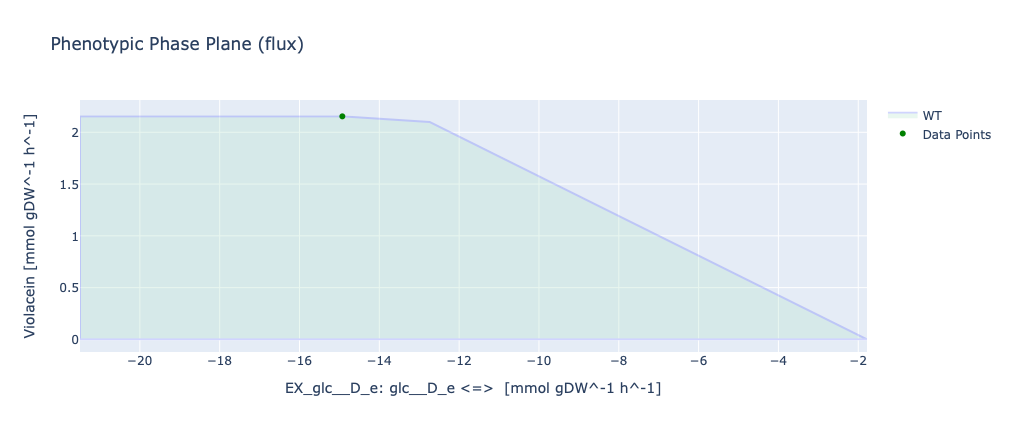

Setting glucose boundary to -21.5 and oxygen to -61:
- The optimal glucose uptake for Violacein flux is [mmol gDW^-1 h^-1]: -14.92685665727615
- The optimal Cmol Glucose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -2.4878094428793585
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 0.8930785785011198
- Max. violacein production [mmol gDW^-1 h^-1]: 2.1538461538461555
- Theoretical maximum yield per carbon [mmol_vio / Cmol_glc]: 0.8657601007227153


In [224]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    # Setting the medium and boundary conditions
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_M9_vio_fad.reactions.EX_glc__D_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_M9_vio_fad.optimize().fluxes.Growth
    model_M9_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    # Phenotypic phase plane of glucose-violacein
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glc__D_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    
    # Computing the glucose uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_glc__D_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of glucose
    cmol = (max(v)/6)
    
    # Computing maximum yield
    violacein_glc_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    
    print('Setting glucose boundary to -21.5 and oxygen to -61:')
    print("- The optimal glucose uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol Glucose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_glc]:', violacein_glc_yield)

## Sucrose as substrate

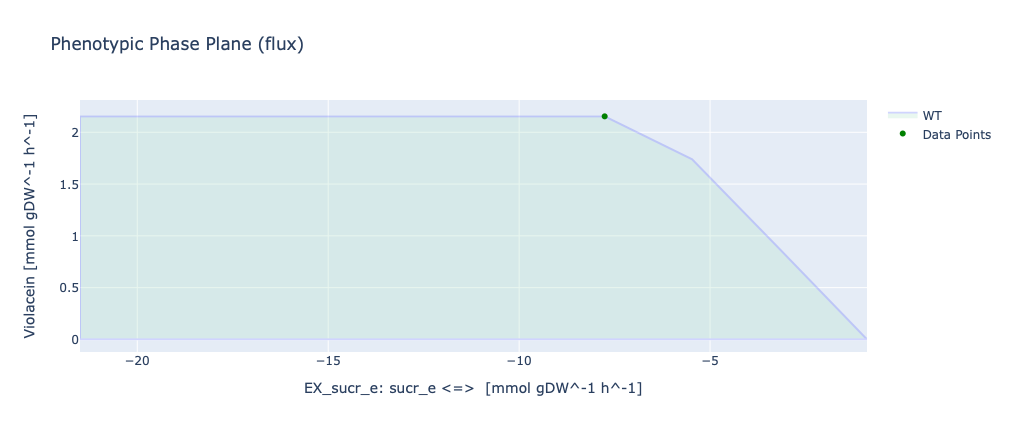

Setting sucrose boundary to -21.5 and oxygen to -61:
- The optimal sucrose uptake for Violacein flux is [mmol gDW^-1 h^-1]: -7.760189990609479
- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -0.6466824992174566
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 0.8930785785011175
- Max. violacein production [mmol gDW^-1 h^-1]: 2.153846153846152
- Theoretical maximum yield per carbon [mmol_vio / Cmol_sucr]: 3.3306083842573404


In [225]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_sucr_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_M9_vio_fad.reactions.EX_sucr_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_M9_vio_fad.optimize().fluxes.Growth
    model_M9_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of sucrose-violacein
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_sucr_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)

    # Computing the sucrose uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_sucr_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of sucrose
    cmol = (max(v)/12)
    
    # Computing maximum yield
    violacein_sucr_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting sucrose boundary to -21.5 and oxygen to -61:')
    print("- The optimal sucrose uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_sucr]:', violacein_sucr_yield)

## D-mannitol as substrate

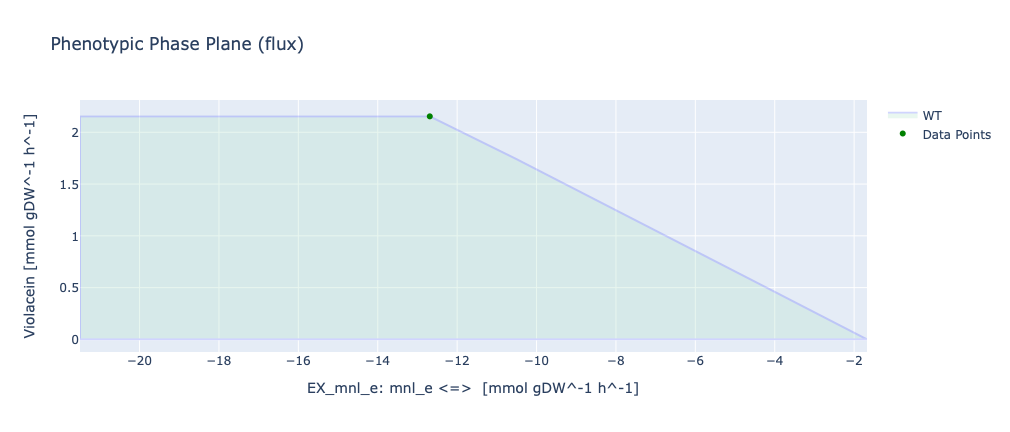

Setting D-mannitol boundary to -21.5 and oxygen to -61:
- The optimal D-mannitol uptake for Violacein flux is [mmol gDW^-1 h^-1]: -12.689258027431523
- The optimal Cmol D-mannitol uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -2.1148763379052538
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 0.8930785785011202
- Max. violacein production [mmol gDW^-1 h^-1]: 2.1538461538461697
- Theoretical maximum yield per carbon [mmol_vio / Cmol_mnl]: 1.0184265222710445


In [226]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_mnl_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_M9_vio_fad.reactions.EX_mnl_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_M9_vio_fad.optimize().fluxes.Growth
    model_M9_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of mannitol-violacein
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_mnl_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    
    # Computing the D-mannitol uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_mnl_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of D-mannitol
    cmol = (max(v)/6)
    
    # Computing maximum yield
    violacein_mnl_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting D-mannitol boundary to -21.5 and oxygen to -61:')
    print("- The optimal D-mannitol uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol D-mannitol uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_mnl]:', violacein_mnl_yield)

## N-acetyl-D-glucosamine as substrate

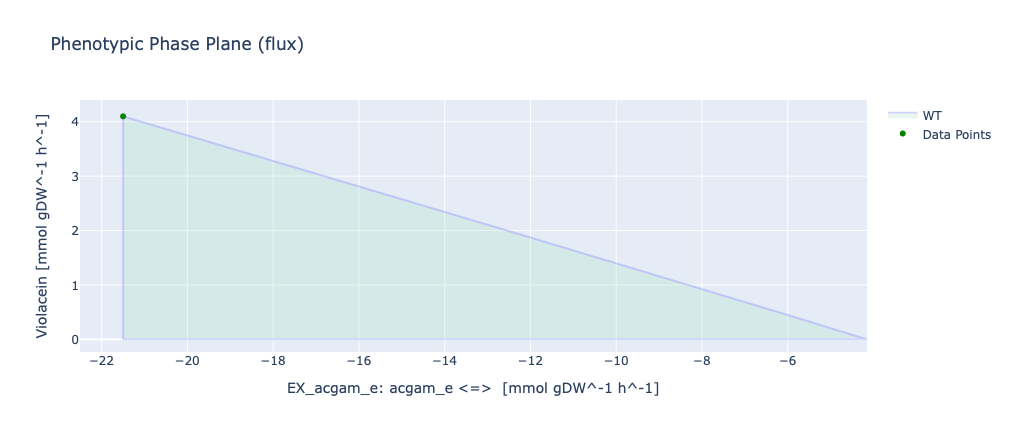

Setting N-acetyl-D-glucosamine boundary to -21.5 and oxygen to -61:
- The optimal N-acetyl-D-glucosamine uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -2.6875
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 2.7259646335567136
- Max. violacein production [mmol gDW^-1 h^-1]: 4.097950212681082
- Theoretical maximum yield per carbon [mmol_vio / Cmol_acgam]: 1.5248186837883095


In [227]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_acgam_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_M9_vio_fad.reactions.EX_acgam_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_M9_vio_fad.optimize().fluxes.Growth
    model_M9_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of glycerol-violacein
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_acgam_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    
    # Computing the N-acetyl-D-glucosamine uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_acgam_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of N-acetyl-D-glucosamine
    cmol = (max(v)/8)
    
    # Computing maximum yield
    violacein_acgam_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting N-acetyl-D-glucosamine boundary to -21.5 and oxygen to -61:')
    print("- The optimal N-acetyl-D-glucosamine uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_acgam]:', violacein_acgam_yield)

## Glycerol as substrate

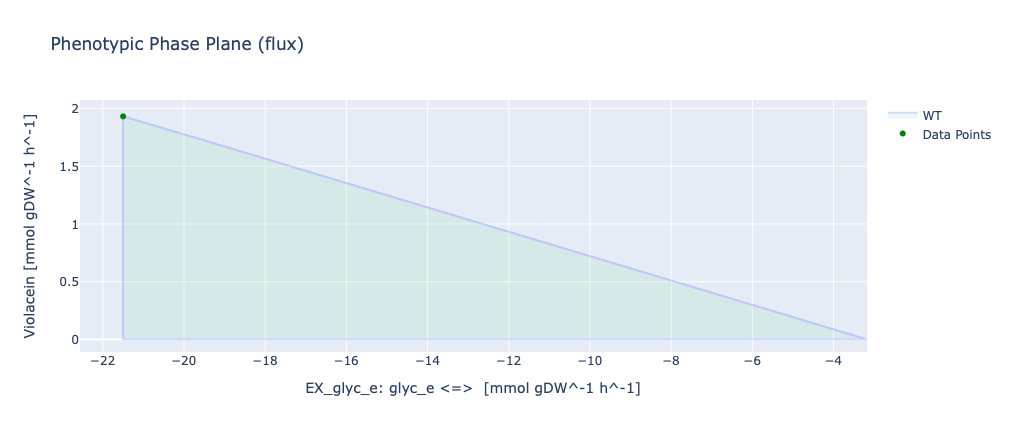

Setting glycerol boundary to -21.5 and oxygen to -61:
- The optimal glycerol uptake for Violacein flux is [mmol gDW^-1 h^-1]: -21.5
- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]: -7.166666666666667
- Growth rate for maximum violacein production in V. natriegens [h^-1]: 0.8930785785011159
- Max. violacein production [mmol gDW^-1 h^-1]: 1.9318062257327637
- Theoretical maximum yield per carbon [mmol_vio / Cmol_glyc]: 0.2695543570789903


In [228]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_glyc_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -61
    model_M9_vio_fad.reactions.EX_glyc_e.lower_bound = -21.5
    
    # Setting the growth to 20% and limiting the rate
    growth = model_M9_vio_fad.optimize().fluxes.Growth
    model_M9_vio_fad.reactions.Growth.lower_bound = growth*0.2
    
    # Setting the objective to violacein
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    # Phenotypic phane plane of glycerol-violacein
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glyc_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)

    # Computing the glycerol uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_glyc_e[round(data.objective_upper_bound,4) == maxvio]
    # Cmol of glycerol
    cmol = (max(v)/3)
    
    # Computing maximum yield
    violacein_glyc_yield = violacein_production / (-1*cmol)
    
    # Plotting phenotypic phase plane
    x = max(v)
    y = maxvio
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting glycerol boundary to -21.5 and oxygen to -61:')
    print("- The optimal glycerol uptake for Violacein flux is [mmol gDW^-1 h^-1]:", max(v))
    print("- The optimal Cmol sucrose uptake for Violacein flux is [Cmol gDW^-1 h^-1]:", cmol)
    print('- Growth rate for maximum violacein production in V. natriegens [h^-1]:', growth)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield per carbon [mmol_vio / Cmol_glyc]:', violacein_glyc_yield)